<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/AutoEncoder_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist

In [2]:
# Load the data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), constant_values=0)
test_images = np.pad(test_images, ((0, 0), (2, 2), (2, 2)), constant_values=0)
train_images = train_images.reshape(
                  (len(train_images), 32*32)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

4422102/4422102 [==============================] - 1s 0us/step


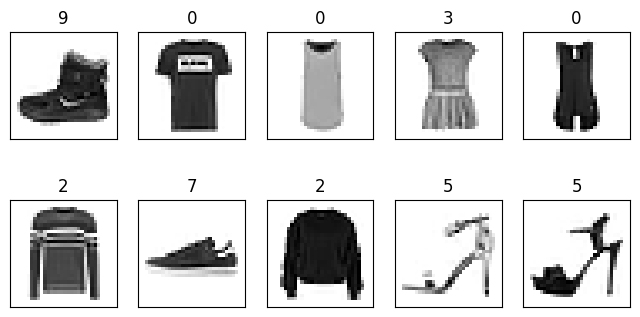

In [3]:
fig = plt.figure(figsize=(8, 4))
for c, (image, label) in enumerate(zip(train_images[:10], train_labels[:10])):
    subplot = fig.add_subplot(2, 5, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(label))
    subplot.imshow(image.reshape((32, 32)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

In [4]:
encoder = models.Sequential()
encoder.add(layers.Reshape((32, 32, 1), input_shape=(32*32,), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter1')) # 16 * 16 * 32
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter2')) # 8 * 8 * 64
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter3')) # 4 * 4 * 128
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(2, name='embedding_space'))


encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv_filter1 (Conv2D)       (None, 16, 16, 32)        320       
                                                                 
 conv_filter2 (Conv2D)       (None, 8, 8, 64)          18496     
                                                                 
 conv_filter3 (Conv2D)       (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 embedding_space (Dense)     (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-traina

In [5]:
decoder = models.Sequential()
decoder.add(layers.Dense(4 * 4 * 128, input_shape=(2, ), name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape2'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose1')) # 8 * 8 * 64
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose2')) # 16 * 16 * 32
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                        activation='sigmoid', name='conv_transpose3')) # 32 * 32 * 1
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 expand (Dense)              (None, 2048)              6144      
                                                                 
 reshape2 (Reshape)          (None, 4, 4, 128)         0         
                                                                 
 conv_transpose1 (Conv2DTran  (None, 8, 8, 64)         73792     
 spose)                                                          
                                                                 
 conv_transpose2 (Conv2DTran  (None, 16, 16, 32)       18464     
 spose)                                                          
                                                                 
 conv_transpose3 (Conv2DTran  (None, 32, 32, 1)        289       
 spose)                                                          
                                                      

In [6]:
model_input = tf.keras.Input(shape=(32*32,))
model = models.Model(model_input, decoder(encoder(model_input)))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 sequential (Sequential)     (None, 2)                 96770     
                                                                 
 sequential_1 (Sequential)   (None, 1024)              98689     
                                                                 
Total params: 195,459
Trainable params: 195,459
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='mse')

In [8]:
def show_result():
    results = model.predict(test_images[:8], verbose=0)

    fig = plt.figure(figsize=(16, 2.7))
    for i in range(8):
      subplot = fig.add_subplot(2, 10, i+1)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(test_images[i].reshape((32, 32)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

      subplot = fig.add_subplot(2, 10, i+11)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(results[i].reshape((32, 32)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

300/300 [==============================] - 14s 6ms/step - loss: 0.0621


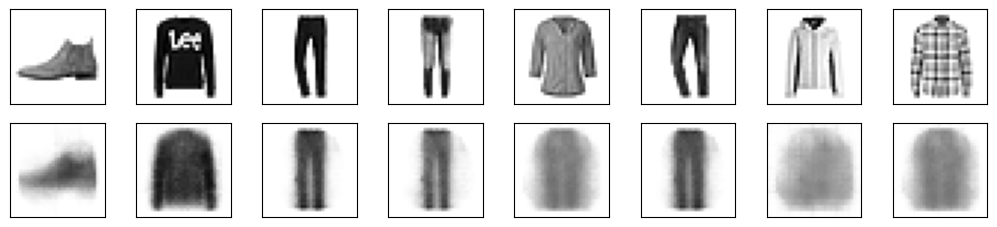

In [9]:
history = model.fit(train_images[:30000], train_images[:30000],
                    batch_size=100, epochs=1)
show_result()

Epoch 1/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0287
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0252
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0242
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0235
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0231
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0227
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0224
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0222
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0220
Epoch 10/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0218
Epoch 11/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0216
Epoch 12/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0215
Epoch 13/50
600/600 [====

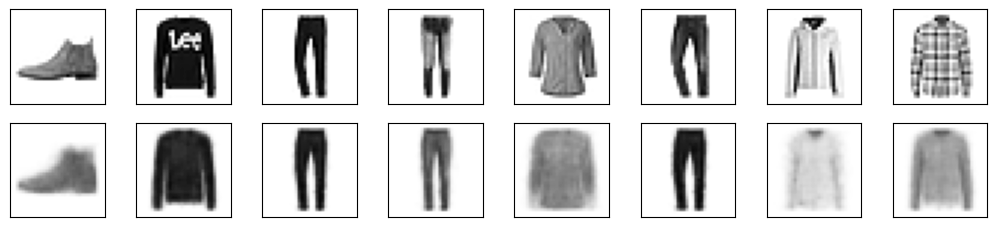

In [10]:
history = model.fit(train_images, train_images,
                    batch_size=100, epochs=50)
show_result()

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
encoder.save('/content/gdrive/My Drive/encoder_FashionMNIST.hd5', save_format='h5')
decoder.save('/content/gdrive/My Drive/decoder_FashionMNIST.hd5', save_format='h5')

ls: cannot access '/content/gdrive/My Drive/*FashionMNIST.hd5': No such file or directory


In [22]:
!ls -lh '/content/gdrive/My Drive/encoder_FashionMNIST.hd5'
!ls -lh '/content/gdrive/My Drive/decoder_FashionMNIST.hd5'

-rw------- 1 root root 400K Jun 29 00:27 '/content/gdrive/My Drive/encoder_FashionMNIST.hd5'
-rw------- 1 root root 407K Jun 29 00:27 '/content/gdrive/My Drive/decoder_FashionMNIST.hd5'
